In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from lmfit.models import ExponentialModel
import json
import lmfit
from matplotlib.ticker import FuncFormatter
import scipy.constants as sc

In [3]:
import matplotlib as mpl

# Set Helvetica font globally
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = ['Helvetica']

# Optional: make sure fonts are updated
mpl.rcParams['pdf.fonttype'] = 42  # Avoids Type 3 fonts in PDF output
mpl.rcParams['ps.fonttype'] = 42

def thousands(x, pos):
    'The two args are the value and tick position, helper fn'
    return '%1.2f' % (x * 1e3)

formatter = FuncFormatter(thousands)

In [4]:
def fit_decay(x, y):
    # Fit data to single exponential decay model
    model = ExponentialModel()
    params = model.guess(y, x = x)
    result = model.fit(y, params, x = x)
    return result

In [7]:
file_name = '25_a'
df = pd.read_csv(f'/Users/edricchoi/LucksLab Dropbox/LucksLab/Lucks_Lab_Papers/In_Progress/88_EKC_Probing_model/Manuscript/Data_elements/03_nmr_dms_degradation/NMR_data/peak_integrals/{file_name}.csv')
decay_fit = fit_decay(df.iloc[:, 0], df.iloc[:, 1])
decay_fit

In [ ]:
def plot_decay_tc(file_name, temp, ax, cmap, norm):
    df = pd.read_csv(f'/Users/edricchoi/LucksLab Dropbox/LucksLab/Lucks_Lab_Papers/In_Progress/88_EKC_Probing_model/Manuscript/Data_elements/03_nmr_dms_degradation/NMR_data/peak_integrals/{file_name}.csv')
    decay_fit = fit_decay(df.iloc[:, 0], df.iloc[:, 1])
    decay_param = decay_fit.params['decay']

    x_vals = np.linspace(0, 7500, 100)
    y_vals = np.exp(-(1 / decay_param) * x_vals)
    color = cmap(norm(temp))
    ax.plot(x_vals / 3600., y_vals, label=f'{temp} °C', color=color)

/var/folders/k7/k3x4cyj90rz6_py6pr8yth9m0000gn/T/ipykernel_65596/3548588682.py:44: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('viridis')
/opt/homebrew/Caskroom/miniconda/base/envs/data_analysis/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/k7/k3x4cyj90rz6_py6pr8yth9m0000gn/T/ipykernel_65596/3548588682.py:76: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


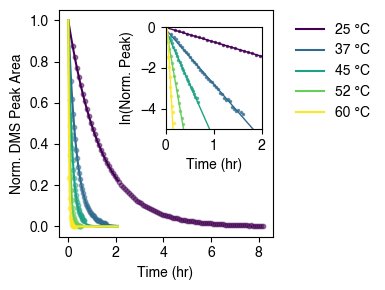

In [55]:
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1.inset_locator import inset_axes


def plot_decay_tc(file_name, temp, ax, inset_ax, cmap, norm):
    df = pd.read_csv(f'/Users/edricchoi/LucksLab Dropbox/LucksLab/Lucks_Lab_Papers/In_Progress/88_EKC_Probing_model/Manuscript/Data_elements/03_nmr_dms_degradation/NMR_data/peak_integrals/{file_name}.csv')
    decay_fit = fit_decay(df.iloc[:, 0], df.iloc[:, 1])
    decay_param = decay_fit.params['decay']
    amplitude = decay_fit.params['amplitude']
    x_vals = np.linspace(0, 7500, 100)
    y_vals = np.exp(-(1 / decay_param) * x_vals)
    y_data = df.iloc[:, 1] / amplitude  # Normalize by amplitude
    # lin transform
    y_lin = np.log(y_data)
    color = cmap(norm(temp))
    ax.scatter(df.iloc[:, 0] / 3600., y_data, color=color, s=10, alpha=0.5)
    ax.plot(x_vals / 3600., y_vals, label=f'{temp} °C', color=color)


    # Inset plot: ln(y)
    inset_ax.plot(df.iloc[:, 0] / 3600., y_lin, 'o', color=color, markersize=1.5, alpha=0.7)
    # linear fit 

    # Compute log and mask invalid values
    with np.errstate(divide='ignore', invalid='ignore'):
        y_lin = np.log(y_data)

    # Mask for finite values only
    x_hr = df.iloc[:, 0].values / 3600.
    valid_mask = np.isfinite(y_lin)

    # Apply mask before polyfit
    coeffs = np.polyfit(x_hr[valid_mask], y_lin[valid_mask], 1)
    slope, intercept = coeffs
    x_fit = np.linspace(0, 10, 100)
    y_fit = slope * x_fit + intercept
    inset_ax.plot(x_fit, y_fit, '-', color=color, linewidth=1)


# Define temperature values and normalization
temps = [25, 37, 45, 52, 60]
norm = mcolors.Normalize(vmin=min(temps), vmax=max(temps))
cmap = cm.get_cmap('viridis')

fig, ax = plt.subplots(figsize=(4, 3))


# Add inset axis

inset_ax = inset_axes(
    ax,
    width="45%", height="45%",
    bbox_to_anchor=(0.5, -0.075, 1, 1),  # must be 4-tuple when using "%"-based size
    bbox_transform=ax.transAxes,
    loc='upper left',
    borderpad=0
)#inset_ax.tick_params()
inset_ax.set_xlabel('Time (hr)')
inset_ax.set_ylabel('ln(Norm. Peak)')

# xlim 0 - 6, ylim 0 to -5
inset_ax.set_xlim(0, 2)
inset_ax.set_ylim(-5, 0)

# Main plot
plot_decay_tc('25_a', 25, ax, inset_ax, cmap, norm)
plot_decay_tc('37_a', 37, ax, inset_ax, cmap, norm)
plot_decay_tc('45_a', 45, ax, inset_ax, cmap, norm)
plot_decay_tc('52_a', 52, ax, inset_ax, cmap, norm)
plot_decay_tc('60_a', 60, ax, inset_ax, cmap, norm)

ax.legend(frameon=False, loc='upper left', bbox_to_anchor=(1.05, 1.0), )
ax.set_xlabel('Time (hr)')
ax.set_ylabel('Norm. DMS Peak Area')
plt.tight_layout()
plt.savefig('dms_nmr_decay.pdf')

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


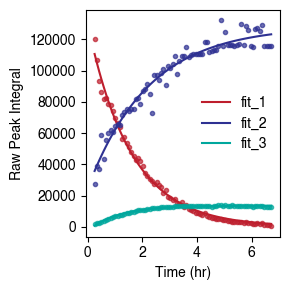

In [68]:

df = pd.read_csv('/Users/edricchoi/LucksLab Dropbox/LucksLab/Lucks_Lab_Papers/In_Progress/88_EKC_Probing_model/Manuscript/Data_elements/03_nmr_dms_degradation/NMR_data/20230726-DMS-only-25b-schwalbe/all_products_25C.csv')

# Define time column and signal/fit pairs
time = df.iloc[:, 0] / 3600  # convert seconds to hours
pairs = [
    ('Integral(3.916,3.888)', 'fit_1'),
    ('Integral(3.622,3.587)', 'fit_2'),
    ('Integral(2.917,2.891)', 'fit_3'),
]
colors = ['#be1e2d', '#2e3192', '#00a79d']

# Plot
plt.figure(figsize=(3, 3))
for (raw, fit), color in zip(pairs, colors):
    plt.plot(time, df[raw], 'o', color=color, markersize=3, alpha=0.7)
    plt.plot(time, df[fit], '-', label=f'{fit}', color=color)

plt.xlabel('Time (hr)')
plt.ylabel('Raw Peak Integral')
plt.legend(frameon=False)
plt.tight_layout()
plt.savefig('dms_nmr_integrals.pdf')
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(4, 3))

ax.legend(frameon=False, loc='upper left', bbox_to_anchor=(1.05, 1.0), )
ax.set_xlabel('Time (hr)')
ax.set_ylabel('Norm. DMS Peak Area')
plt.tight_layout()
plt.savefig('dms_products.pdf')

,Ea_kcal_per_mol,Ea_error,lnA,lnA_error
group,,,,
nmr,20.999840,1.711583,26.885756,2.734402
4U_wt,18.762551,2.469306,23.452496,3.946536
4U_a8c,19.694234,2.495644,25.178269,3.985959


In [ ]:
import numpy as np
import pandas as pd
from scipy.constants import R, calorie

# Constants
R_val = R / (1000 * calorie)  # kcal/mol/K

# Base values from NMR (reference group)
slope_nmr = model.params['inv_temp']
slope_err_nmr = model.bse['inv_temp']
intercept_nmr = model.params['Intercept']
intercept_err_nmr = model.bse['Intercept']

# Collect values for each group
groups = ['nmr', '4U_wt', '4U_a8c']
results = []

for group in groups:
    if group == 'nmr':
        slope = slope_nmr
        slope_err = slope_err_nmr
        intercept = intercept_nmr
        intercept_err = intercept_err_nmr
    else:
        slope = slope_nmr + model.params[f'inv_temp:C(disp_name, Treatment(reference="nmr"))[T.{group}]']
        slope_err = np.sqrt(
            slope_err_nmr**2 +
            model.bse[f'inv_temp:C(disp_name, Treatment(reference="nmr"))[T.{group}]']**2
        )

        intercept = intercept_nmr + model.params[f'C(disp_name, Treatment(reference="nmr"))[T.{group}]']
        intercept_err = np.sqrt(
            intercept_err_nmr**2 +
            model.bse[f'C(disp_name, Treatment(reference="nmr"))[T.{group}]']**2
        )

    Ea = -slope * R_val
    Ea_err = slope_err * R_val

    results.append({
        'group': group,
        'Ea_kcal_per_mol': Ea,
        'Ea_error': Ea_err,
        'lnA': intercept,
        'lnA_error': intercept_err
    })

# Create DataFrame
df_arrhenius = pd.DataFrame(results)
df_arrhenius = df_arrhenius.set_index('group')

df_arrhenius

,Ea_kcal_per_mol,Ea_error,lnA,lnA_error
group,,,,
nmr,20.999840,1.711583,26.885756,2.734402
4U_wt,18.762551,2.469306,23.452496,3.946536
4U_a8c,19.694234,2.495644,25.178269,3.985959


### Eyring equation

$\ln\left(\frac{k}{T}\right) = -\left(\frac{\Delta H^\ddagger}{R}\cdot\frac{1}{T}\right) + \left(\frac{\Delta S^\ddagger}{R} + \ln\left(\frac{k_b}{h}\right)\right)$

- equation that describes the changes in the rate of a chemical reaction against the temperature of the reaction mixture
- equation based on the statistical mechanical justification
- useful in the transition state theory and there, it is known as the activated-complex theory

### Arrhenius equation

$\ln(k) = -\left(\frac{E_a}{R}\cdot\frac{1}{T}\right) + \ln(A)$

- chemical formula that involves the temperature dependence of reaction rates
- an empirical equation
- to model the temperature variation of thermally induced processes

In [77]:
sc.Planck # h, J Hz^-1
sc.Boltzmann # kb, J K^-1
np.log(sc.Boltzmann / sc.Planck) # ln(kb/h)

np.float64(23.759977810504218)

In [71]:
sc.R # gas constant in J mol-1 K-1
sc.R/sc.calorie # gas constant in cal mol-1 K-1

1.9872042586408316

20374.358580304863 219.96621547282152
-7.207121652956311 0.6983336013778239


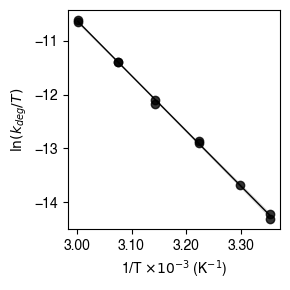

In [82]:
### NMR degradation data

temps = []
reps = []
kdeg_vals = []

for temp in [25, 30, 37, 45, 52, 60]:
    for rep in ['a', 'b']:
        if temp == 30 and rep =='b':
            continue
        # read json-like file /home/ekc5108/b1044/Computational_Output/EKC/EKC.01_SHAPE_standardization/EKC.01.058.XSB_training_DMS/nmr_dms_deg/52_a.sav
        with open(f'/Users/edricchoi/LucksLab Dropbox/LucksLab/Lucks_Lab_Papers/In_Progress/88_EKC_Probing_model/Manuscript/Data_elements/data/nmr_dms_deg/{temp}_{rep}.sav') as f:
            data = json.load(f)
        kdeg_val = 1 / data['params'][1][1]
        temps.append(temp)
        reps.append(rep)
        kdeg_vals.append(kdeg_val)

df_kdeg = pd.DataFrame({'temperature': temps, 'replicate': reps, 'kdeg': kdeg_vals})
df_kdeg['lnkdeg'] = np.log(df_kdeg['kdeg'])
df_kdeg['inv_temp'] = 1 / (df_kdeg['temperature'] + 273.15)
df_kdeg['lnkdegT'] = np.log(df_kdeg['kdeg'] * df_kdeg['inv_temp'])


# linear fit to get curve
model = lmfit.models.LinearModel()
params = model.make_params()
deg_result = model.fit(df_kdeg['lnkdegT'], params, x=df_kdeg['inv_temp'])

# calculate thermoparams
m = deg_result.params['slope'].value
m_err = deg_result.params['slope'].stderr
b = deg_result.params['intercept'].value
b_err = deg_result.params['intercept'].stderr

dH = - m * sc.R/sc.calorie
dH_err = m_err * sc.R/sc.calorie
dS = (b - np.log(sc.Boltzmann / sc.Planck)) * sc.R/sc.calorie
dS_err = b_err * sc.R/sc.calorie

print(dH, dH_err)
print(dS, dS_err)

fig, ax = plt.subplots(figsize=(3, 3))
sns.regplot(x='inv_temp', y='lnkdegT', data=df_kdeg, ax=ax, color='black', line_kws={'linewidth': 1})

ax.xaxis.set_major_formatter(formatter)
ax.set_ylabel(r'$\ln(k_{deg} / T)$')
ax.set_xlabel(r'1/T $\times 10^{-3}$ (K$^{-1}$)')
plt.tight_layout()
plt.show()

deg_result

In [4]:
## Arrhenius version

20999.839893947392 220.06679765639615
6.2115597722298554 0.6986529227733844


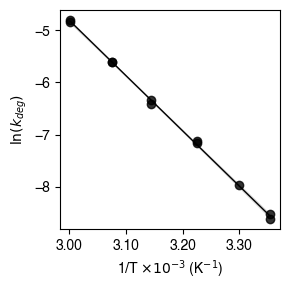

In [5]:
### NMR degradation data

temps = []
reps = []
kdeg_vals = []

for temp in [25, 30, 37, 45, 52, 60]:
    for rep in ['a', 'b']:
        if temp == 30 and rep =='b':
            continue
        # read json-like file /home/ekc5108/b1044/Computational_Output/EKC/EKC.01_SHAPE_standardization/EKC.01.058.XSB_training_DMS/nmr_dms_deg/52_a.sav
        with open(f'/Users/edricchoi/LucksLab Dropbox/LucksLab/Lucks_Lab_Papers/In_Progress/88_EKC_Probing_model/Manuscript/Data_elements/data/nmr_dms_deg/{temp}_{rep}.sav') as f:
            data = json.load(f)
        kdeg_val = 1 / data['params'][1][1]
        temps.append(temp)
        reps.append(rep)
        kdeg_vals.append(kdeg_val)

df_kdeg = pd.DataFrame({'temperature': temps, 'replicate': reps, 'kdeg': kdeg_vals})
df_kdeg['lnkdeg'] = np.log(df_kdeg['kdeg'])
df_kdeg['inv_temp'] = 1 / (df_kdeg['temperature'] + 273.15)


# linear fit to get curve
model = lmfit.models.LinearModel()
params = model.make_params()
deg_result = model.fit(df_kdeg['lnkdeg'], params, x=df_kdeg['inv_temp'])

# calculate thermoparams
m = deg_result.params['slope'].value
m_err = deg_result.params['slope'].stderr
b = deg_result.params['intercept'].value
b_err = deg_result.params['intercept'].stderr

dH = - m * sc.R/sc.calorie
dH_err = m_err * sc.R/sc.calorie
dS = (b - np.log(sc.Boltzmann / sc.Planck)) * sc.R/sc.calorie
dS_err = b_err * sc.R/sc.calorie

print(dH, dH_err)
print(dS, dS_err)

fig, ax = plt.subplots(figsize=(3, 3))
sns.regplot(x='inv_temp', y='lnkdeg', data=df_kdeg, ax=ax, color='black', line_kws={'linewidth': 1})

ax.xaxis.set_major_formatter(formatter)
ax.set_ylabel(r'$\ln(k_{deg})$')
ax.set_xlabel(r'1/T $\times 10^{-3}$ (K$^{-1}$)')
plt.tight_layout()
plt.show()

deg_result